**Project:** Sentiment Analysis of [Amazon Product Reviews](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews)

**Author:** [Giuseppe Muschetta](https://github.com/peppe212)

**Python version:** 3.8

### CLASSIFICATION WITH NAÏVE BAYES
**Model:** [sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

In [1]:
# Sopprimiamo i fastidiosissimi warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (roc_curve, 
                             auc, 
                             ConfusionMatrixDisplay, 
                             classification_report, 
                             confusion_matrix, 
                             accuracy_score,
                             precision_recall_curve,
                             average_precision_score)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from pathlib import Path
import joblib

#### Ipostazione dei path

In [3]:
# Caricamento del Dataset già pulito
DATASET_PATH = Path() / "Dataset/cleaned_reviews.csv"
df = pd.read_csv(DATASET_PATH)
if df.isna().any().any():
    df.fillna("", inplace=True)

# Impostazione path per il salvataggio immagini
IMAGES_PATH = Path() / "Images" / "MultinomialNB"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_my_image(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

# Gestione salvataggio e caricamento del modello di MultinomialNB
MODEL_PATH = Path() / "Saved_models" / "MultinomialNB"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Salva il modello su un file di estensione default.tf
def save_my_model(model, model_name='MultinomialNB', model_extension="joblib"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    try:
        # salva il modello utilizzando la libreria joblib
        joblib.dump(model, path)
        print(f"Modello salvato correttamente in: {path}")
    except Exception as e:
        print(f"Si è verificato un errore durante il salvataggio del modello: {e}")
        raise FileNotFoundError
#end_function

# Carica il modello dal file con estensione a default.tf
def load_my_model(model_name='MultinomialNB', model_extension="joblib"):
    path = MODEL_PATH / f"{model_name}.{model_extension}"
    if path.exists():
        try:
            model = joblib.load(path)
            print(f"Modello caricato correttamente da: {path}")
            return model
        except Exception as e:
            print(f"Si è verificato un errore durante il caricamento del modello: {e}")
            raise
    else:
        error_msg = f"Il file del modello non esiste: {path}"
        print(error_msg)
        raise FileNotFoundError(error_msg)
#end_function

### Train-Test Split and proportions

In [4]:
# Preparazione dei dati
# Questa cella va eseguita anche se l'intenzione è di caricare il modello da file joblib
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'],
                                                    df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['sentiment'])

# Statistiche sulle proporzioni del dataset
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])

print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', str(sum(y_train == 1)/ len(y_train) * 100.0))
print ('Negative Sentiment ', str(sum(y_train == 0)/ len(y_train) * 100.0))

print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', str(sum(y_test == 1)/ len(y_test) * 100.0))
print ('Negative Sentiment ', str(sum(y_test == 0)/ len(y_test) * 100.0))


Size of Training Data  131259
Size of Test Data  32815
Distribution of classes in Training Data :
Positive Sentiment  50.00038092626029
Negative Sentiment  49.9996190737397
Distribution of classes in Testing Data :
Positive Sentiment  49.99847630656712
Negative Sentiment  50.00152369343288


### TRAINING THE NAÏVE BAYES MODEL

In [5]:
# Vettorizzazione
tfidf = TfidfVectorizer(stop_words='english')

# Selezione delle k migliori feature:
selkbest = SelectKBest(score_func=chi2)

# Modello
model = MultinomialNB()

# Fase 3: Tuning degli iper-parametri
param_grid = {
    # max document frequency:
    'tfidf__max_df': [0.5], #[0.5, 0.75, 0.95, 1],
    # minimum document frequency:
    'tfidf__min_df': [10], #[1, 3, 5, 10],
    # intervallo di engrammi da considerare:
    'tfidf__ngram_range': [(1, 2)], #[(1, 1), (1, 2), (1, 3)],
    # conferisce più peso ai termini meno frequenti, un must per la sentiment analysis
    'tfidf__use_idf': [True], # [True, False]
    # attivare lo smoothing del vettorizzatore
    'tfidf__smooth_idf': [True], # [True, False]
    # seleziona le migliori k feature
    'selkbest__k' : [20000], # [7500, 10000, 15000, 20000]
    # Valori di alpha per lo smoothing del modello
    'model__alpha': [0.5], # [0.01, 0.1, 0.5, 0.75, 1.0, 2.0],
    # Se imparare la probabilità a priori delle classi o utilizzare
    # una distribuzione uniforme bypassando la distribuzione delle classi
    'model__fit_prior': [True] #[True, False]
}

# Istanzio una pipeline per automatizzare il tutto
estimator = Pipeline(steps=[('tfidf', tfidf), ('selkbest', selkbest), ('model', model)])

# Imposto una grid search con Cross Validation a 5 folds
grid_search_cv = GridSearchCV(estimator=estimator, 
                              param_grid=param_grid, 
                              cv=5, 
                              verbose=1, 
                              n_jobs=-1)

# Fase 4: Avvio del training del modello
grid_search_cv.fit(X_train, y_train)

# cerchiamo di capire quali sono i migliori iper-parametri
best_params = grid_search_cv.best_params_
print("Best iper-parameters identified by grid search are: ", best_params)

best_result = grid_search_cv.best_score_
print("Best result identified by grid search are: ", best_result)

# In questa variabile conserviamo il best model
best_model = grid_search_cv.best_estimator_

# Fase 5: Valutazione del Modello:
y_pred = best_model.predict(X_test)
print("Accuracy - ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# I migliori parametri rilevati sono: 
# 'model__alpha': 0.5, 
# 'model__fit_prior': True, 
# 'selkbest__k': 20000, 
# 'tfidf__max_df': 0.5, 
# 'tfidf__min_df': 10, 
# 'tfidf__ngram_range': (1, 2), 
# 'tfidf__smooth_idf': True, 
# 'tfidf__use_idf': True

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best iper-parameters identified by grid search are:  {'model__alpha': 0.5, 'model__fit_prior': True, 'selkbest__k': 15000, 'tfidf__max_df': 0.5, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': True, 'tfidf__use_idf': True}
Best result identified by grid search are:  0.8938587005382171
Accuracy -  0.8923053481639495
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     16408
           1       0.88      0.90      0.89     16407

    accuracy                           0.89     32815
   macro avg       0.89      0.89      0.89     32815
weighted avg       0.89      0.89      0.89     32815

Confusion Matrix:
 [[14433  1975]
 [ 1559 14848]]


### Saving the model on a joblib file

In [6]:
# Salvo il modello già trainato
save_my_model(best_model)

Modello salvato correttamente in: Saved_models/MultinomialNB/MultinomialNB.joblib


### Loading the model from a joblib file

In [7]:
# Carico il modello
model = load_my_model()

Modello caricato correttamente da: Saved_models/MultinomialNB/MultinomialNB.joblib


### VISUALIZZAZIONE DI METRICHE E ROC-CURVE

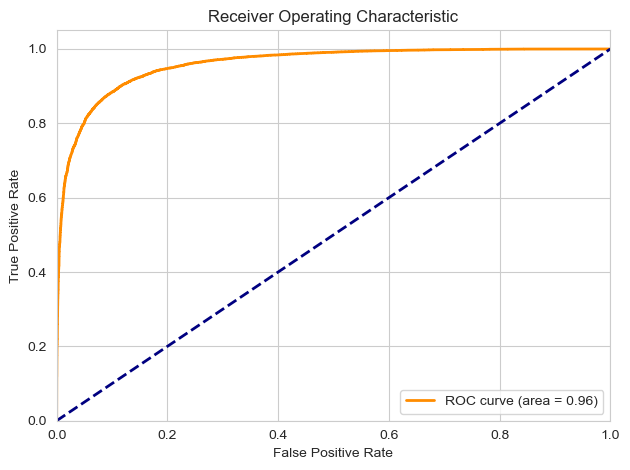

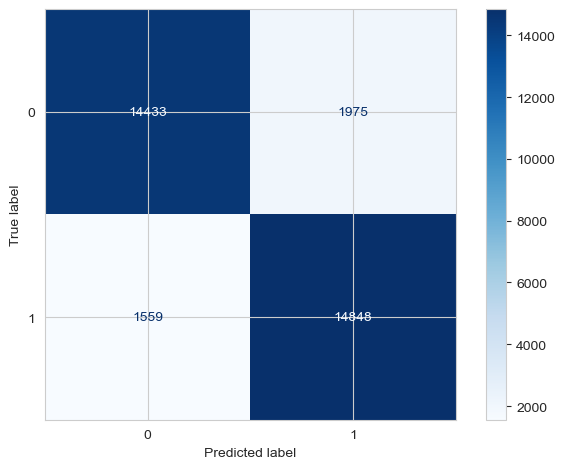

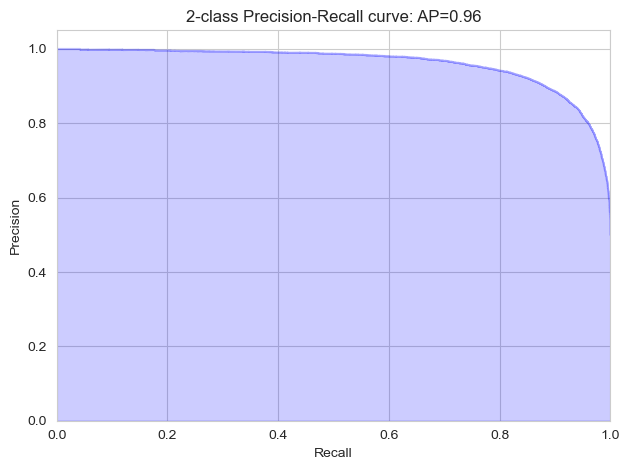

In [8]:
# Predizioni probabilistiche necessarie per la ROC
probabilities = model.predict_proba(X_test)[:, 1]
predictions = model.predict(X_test)

# Calcolo della ROC Curve e AUC
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Visualizzazione della ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
save_my_image("roc_curve")


# Calcolo e visualizzazione della matrice di confusione
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
save_my_image("confusion_matrix")
plt.show()

# Calcolo delle Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, probabilities)
average_precision = average_precision_score(y_test, probabilities)

# Visualizzazione delle Precision-Recall Curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
save_my_image("precision_recall_curve")
plt.show()


### PREDICTING SENTIMENT FROM A REVIEW

In [9]:
# importo il mio script di pulizia del testo
import clean_text_script

def predict_sentiment(model, text):
    """
    Classifica una nuova recensione come positiva o negativa.

    @args:
    review (str): La recensione da classificare.
    model (Pipeline): Il modello di classificazione trainato.

    @returns:
    Str: "positiva" se la recensione è classificata positiva, "negativa" altrimenti.
    """
    prediction = model.predict([text])
    if prediction[0] == 1:
        return "Positiva"
    else:
        return "Negativa"


# SCRIVI QUI UNA RECENSIONE PER PREDIRNE IL SENTIMENT:
# questa recensione è stata presa da amazon americano
review = "Excellent value I love the portability so I can take this on the run in my purse or backpack. Flavor is really good. My only disappointment was the actual size of each bar. Otherwise I thought it was really tasty and would love to buy again."

cleaned_review = clean_text_script.clean_text(review)
# Classificazione della recensione
result = predict_sentiment(model, cleaned_review)
print(f"La recensione è classificata come: {result}")


La recensione è classificata come: Positiva
